In [94]:
import numpy as nu
import matplotlib.pyplot as plt
from galpy.potential import SCFPotential, HernquistPotential,NFWPotential, compute_coeffs_spherical
from IPython.display import display, Math, Latex
%matplotlib inline  

#SCFPotential

## Examples

### Spherical density 

Consider $\rho (r) = \frac{1}{2\pi} \frac{1}{r (1 + r)^3}$

We get $A_{nlm} = \delta_{n0}\delta_{l0}\delta_{m0}$

In [160]:
def rho_Spherical(r):
    return (2*nu.pi)**-1 * (r*(1 + r)**3)**-1

In [161]:
Acos, Asin = compute_coeffs_spherical(rho_Spherical,2)

Creating the SCFPotential object

In [162]:
scf = SCFPotential(1., Acos, Asin)

In [163]:
def calculateSCFDensity(r):
    density = nu.zeros(len(r), float)
    for i in range(len(R)):
        density[i] = scf.dens(R[i], 0)
    return density

In [164]:
R = nu.linspace(0.01, 1., 1000)
density = calculateSCFDensity(R)
densityAnalytic = rho_Spherical(R)

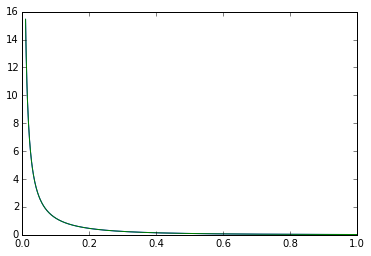

In [165]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

We confirm that our numerical density matches with our analytic density

#### Comparing to Hernquist potential

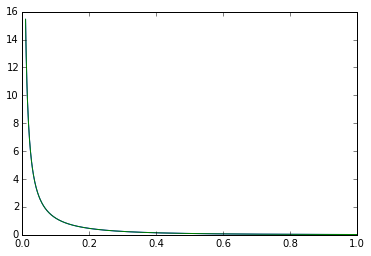

In [166]:
h = HernquistPotential(2., 1.) ## Equation (2.1) and the implemented Hernquist amplitude has a factor 2 difference
z = nu.zeros(len(R))
hDensity = h.dens(R,z)
plt.plot(R, density)
plt.plot(R, hDensity)

Confirmed that the implemented SCF potential matches with the already implemented Hernquist potential.

The only note is amp=2. 

### Zeeuw's perfect ellipsoid

Consider $\rho (r) = \frac{3}{4\pi} \frac{1}{(1 + r)^4}$

We get $A_{nlm} = \frac{3}{4}\delta_{n0}\delta_{l0}\delta_{m0} + \frac{1}{12}\delta_{n1}\delta_{l0}\delta_{m0}$

In [167]:
def rho_Zeeuw(r):
    return 3./(4*nu.pi) * (1. + r)**-4.

In [168]:
Acos, Asin = compute_coeffs_spherical(rho_Zeeuw, 2) 
scf = SCFPotential(1., Acos, Asin)

In [169]:
density = calculateSCFDensity(R)
densityAnalytic = rho_Zeeuw(R)


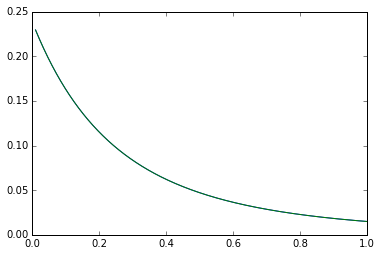

In [170]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

### NFW potential

Consider $\rho (r) = \frac{1}{4\pi} \frac{1}{r (1 + r)^2}$

In [176]:
def rho_NFW(r):
    return (4*nu.pi)**-1 * (r*(1 + r)**2)**-1

In [177]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,1)
scf = SCFPotential(1., Acos, Asin)

In [178]:
density = calculateSCFDensity(R)

In [179]:
nfw = NFWPotential(1., 1.)
nfwDensity = nfw.dens(R,z)

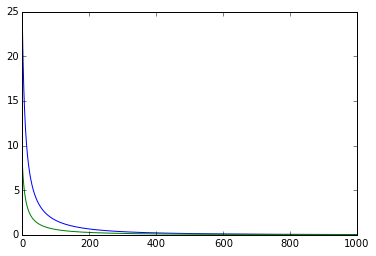

In [180]:
plt.plot(density)
plt.plot(nfwDensity)

As we can see, the function does not match well enough. Let's try increasing the size of the coefficients 

In [181]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,4)
scf = SCFPotential(1., Acos, Asin)
density = calculateSCFDensity(R)

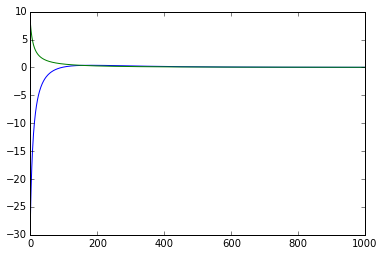

In [182]:
plt.plot(density)
plt.plot(nfwDensity)

It got worse. Let's try increasing it again...

In [183]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,10)
scf = SCFPotential(1., Acos, Asin)
density = calculateSCFDensity(R)

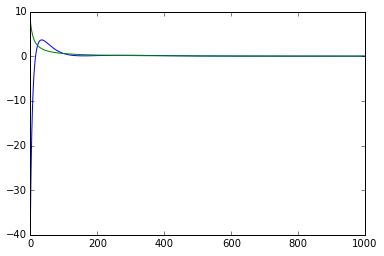

In [184]:
plt.plot(density)
plt.plot(nfwDensity)

Slightly better. Let's try one more time..

In [187]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,100)
scf = SCFPotential(1., Acos, Asin)
density = calculateSCFDensity(R)

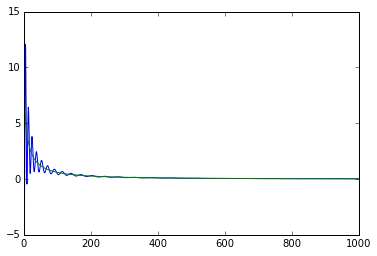

In [188]:
plt.plot(density)
plt.plot(nfwDensity)